# EX 9

Develop neural network-based time series forecasting model.

Step 1: Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Step 1: Load the raw dataset
df_raw = pd.read_csv('AEP_hourly.csv')

# Backup before cleaning for comparison
df_before = df_raw.copy()

In [ ]:
# Step 2: Parse date and sort
df_raw['Datetime'] = pd.to_datetime(df_raw['Datetime'], errors='coerce')
df_raw = df_raw.sort_values('Datetime')
df_raw.set_index('Datetime', inplace=True)

In [ ]:
# Step 3: Save the before-cleaning version for plotting
df_before_cleaning = df_raw['AEP_MW'].copy()

In [ ]:
# Step 4: Cleaning (Handling missing values)
df_cleaned = df_raw.copy()
df_cleaned['AEP_MW'] = df_cleaned['AEP_MW'].fillna(method='ffill')  # Forward fill


<ipython-input-14-72482af686d2>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned['AEP_MW'] = df_cleaned['AEP_MW'].fillna(method='ffill')  # Forward fill


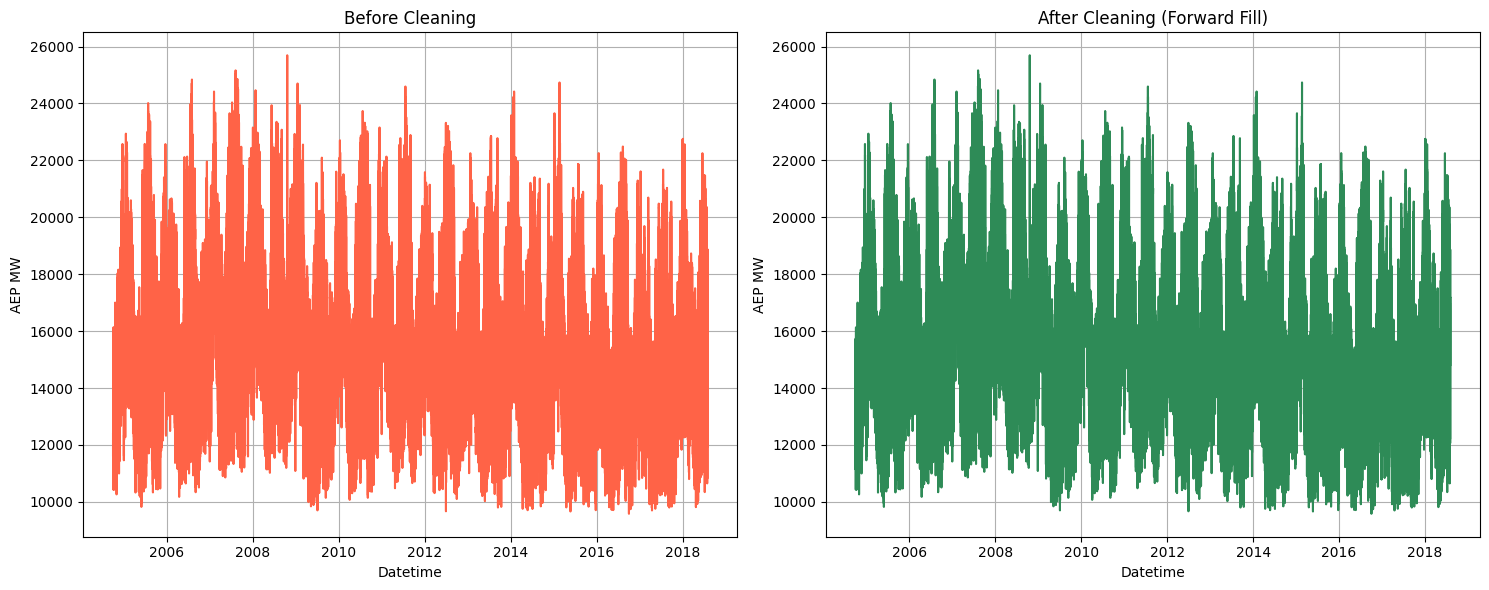

In [ ]:
# Step 5: Plot Before vs After Cleaning
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df_before_cleaning, color='tomato')
plt.title("Before Cleaning")
plt.xlabel("Datetime")
plt.ylabel("AEP MW")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_cleaned['AEP_MW'], color='seagreen')
plt.title("After Cleaning (Forward Fill)")
plt.xlabel("Datetime")
plt.ylabel("AEP MW")
plt.grid(True)

plt.tight_layout()
plt.show()

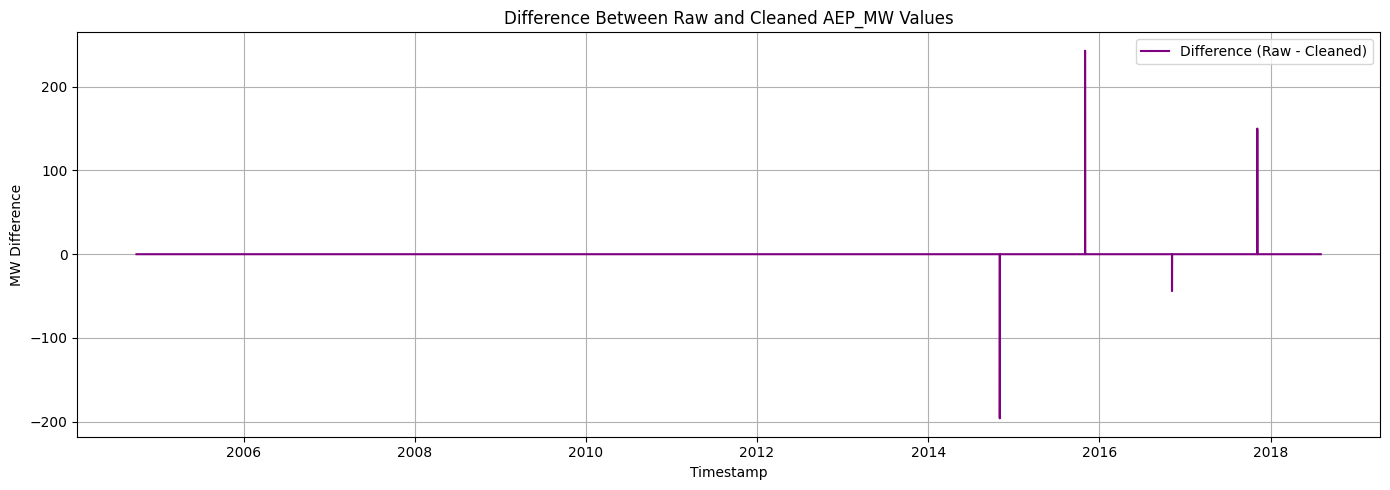

In [ ]:
# Align the original and cleaned data to the same datetime index
df_raw = df.copy()
df_raw = df_raw[~df_raw.index.duplicated(keep='first')]  # Remove duplicate timestamps
df_aligned = df_cleaned.loc[df_cleaned.index.intersection(df_raw.index)]

# Subtract cleaned values from raw values
diff = df_raw.loc[df_aligned.index]['AEP_MW'] - df_aligned['AEP_MW']

# Plotting the difference
plt.figure(figsize=(14, 5))
plt.plot(diff, label="Difference (Raw - Cleaned)", color='purple')
plt.title("Difference Between Raw and Cleaned AEP_MW Values")
plt.xlabel("Timestamp")
plt.ylabel("MW Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [ ]:
# Resample to daily mean to reduce data size
df_daily = df_cleaned.resample('D').mean()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_daily[['AEP_MW']])

In [ ]:
# Create sequences
def create_sequences(data, window_size):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)


In [ ]:
window_size = 30
X, y = create_sequences(scaled_data, window_size)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
y_pred = model.predict(X_test)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0342
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0119
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
# Inverse transform to get actual values
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [ ]:
# Evaluation Metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"🔍 Evaluation Metrics:")
print(f"🔹 MSE  = {mse:.2f}")
print(f"🔹 RMSE = {rmse:.2f}")
print(f"🔹 MAE  = {mae:.2f}")
print(f"🔹 R²   = {r2:.4f}")

🔍 Evaluation Metrics:
🔹 MSE  = 821853.87
🔹 RMSE = 906.56
🔹 MAE  = 713.89
🔹 R²   = 0.7523


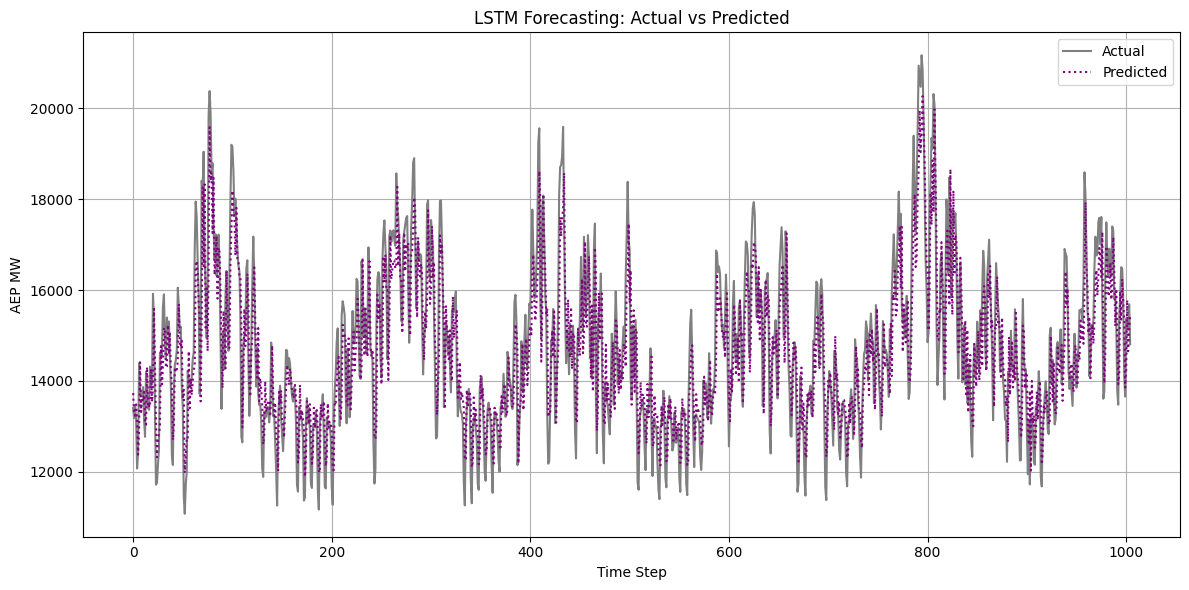

In [ ]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual", color='grey')
plt.plot(y_pred_inv, label="Predicted", color='purple',linestyle="dotted")
plt.title("LSTM Forecasting: Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("AEP MW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()